In [15]:
import pandas as pd
import empyrical as ep
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings("ignore")

In [1]:
vertedero = {

    "malos/BAS.CSV":1,
    "malos/CQY.csv":1,
    "malos/EZN.csv":1,
    "malos/HSM.csv":1
}


In [4]:
df_sessionlogs_vertedero = {}

for informe_path in vertedero:
    multiplicador = vertedero[informe_path]
    df = pd.read_csv(informe_path,parse_dates=True,index_col=['Date'])
    df["Price"] = df["Price"] * multiplicador
    df_sessionlogs_vertedero[informe_path] = df

In [5]:
df_portfolio_basurero = None

for informe_path in df_sessionlogs_vertedero:
    if df_portfolio_basurero is None:
        df_portfolio_basurero = df_sessionlogs_vertedero[informe_path]
        df_portfolio_basurero.columns = [informe_path]
    else:
        df_portfolio_basurero = df_portfolio_basurero.join(df_sessionlogs_vertedero[informe_path].rename(columns={
            "Price":informe_path
        })).fillna(0)

df_portfolio_basurero["total"] = df_portfolio_basurero.sum(axis=1)

In [6]:
peor_sesion_malo = df_portfolio_basurero["total"].min()


cumulative_malo = df_portfolio_basurero["total"].cumsum().values
max_return_malo = np.fmax.accumulate(cumulative_malo)
peor_drawdown_malo = np.nanmin(cumulative_malo - max_return_malo)


capital_sugerido_malo = abs(round(min(5*peor_drawdown_malo,15*peor_sesion_malo),0))


df_estadisticas_malas = pd.DataFrame.from_dict({
    "Peor Sesion": peor_sesion_malo,
    "Peor Drawdown": peor_drawdown_malo,
    "Capital Necesario": capital_sugerido_malo
},"index")

df_estadisticas_malas.columns = ["Darwins BASURA"]

df_estadisticas_malas

,Darwins BASURA
Peor Sesion,-29.16
Peor Drawdown,-79.55
Capital Necesario,437.00


In [12]:
df_returns_malo = (df_portfolio_basurero["total"].cumsum() + capital_sugerido_malo).pct_change().dropna()

df_performance_malo = pd.DataFrame.from_dict({
    "PyG": df_portfolio_basurero["total"].cumsum().values[-1],
    "Sesiones Analizadas": len(df_portfolio_basurero),
    "Sesiones Ganadoras (%)": 100 * len(df_portfolio_basurero[df_portfolio_basurero["total"]>0]) /  len(df_portfolio_basurero[df_portfolio_basurero["total"]!=0]),
    "ROI Anualizado": 100 * ep.annual_return(df_returns_malo),
    "CAGR" :  100 * ep.cagr(df_returns_malo),
    "Volatilidad Anualizada": 100 *  ep.annual_volatility(df_returns_malo),
    "Profit Factor":  df_returns_malo[df_returns_malo > 0].sum() / abs(df_returns_malo[df_returns_malo < 0].sum()),
    "Promedio Sesion Ganadora":  df_portfolio_basurero[df_portfolio_basurero["total"] > 0]["total"].mean(),
    "Promedio Sesion Perdedora":  df_portfolio_basurero[df_portfolio_basurero["total"] < 0]["total"].mean(),
    "Ratio Sharpe": ep.sharpe_ratio(df_returns_malo),
    "Ratio Sortino": ep.sortino_ratio(df_returns_malo),
    "Ratio Calmar" :  ep.calmar_ratio(df_returns_malo),
    "Tail Ratio" : ep.tail_ratio(df_returns_malo),
    "Omega Ratio" : ep.omega_ratio(df_returns_malo),
    "Peor Sesion": peor_sesion_malo,
    "Peor Drawdown": peor_drawdown_malo,
    "Min Bankroll NoBust": capital_sugerido_malo,
    "VAR95%" : ep.value_at_risk(df_returns_malo,0.95),
},"index")

df_performance_malo.columns = ["El Basurero"]

In [13]:
df_performance_malo

,El Basurero
PyG,-7.340000
Sesiones Analizadas,595.000000
Sesiones Ganadoras (%),50.673401
ROI Anualizado,-0.678434
CAGR,-0.678434
Volatilidad Anualizada,14.061705
Profit Factor,1.003832
Promedio Sesion Ganadora,2.815615
Promedio Sesion Perdedora,-2.917543
Ratio Sharpe,0.022088


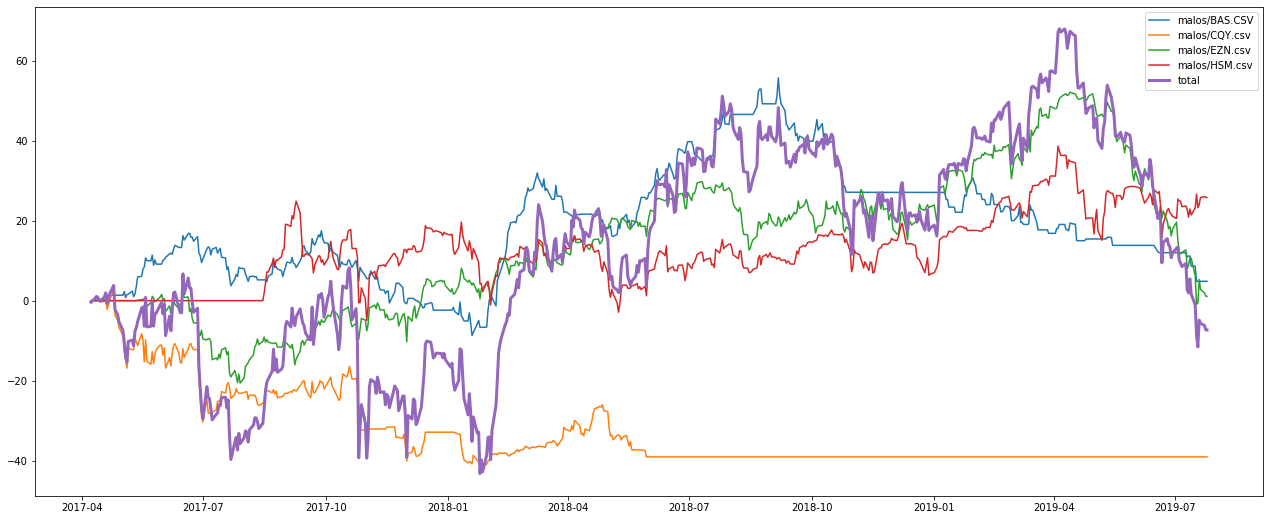

In [18]:
# Graficamos el portfolio
fig = plt.figure(figsize=(22,9))

plt.plot(df_portfolio_basurero.drop("total", axis=1).cumsum())
plt.plot(df_portfolio_basurero["total"].cumsum(), linewidth=3);

leg = plt.legend(df_portfolio_basurero.columns.values)
plt.show()